<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [1]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [2]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True

  !pip install gymnasium

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0', render_mode='human')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [3]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0', render_mode='human')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [4]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [5]:
def choose_action_softmax(
    state: int,
    actions: range,
    q: dict,
    hyperparameters: dict,
    random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """
    # Extrae el valor de temperatura de los hiperparámetros
    temperature = hyperparameters.get('temperature', 1.0)

    # Calcula los valores Q para el estado actual
    q_values = np.array([q.get((state, a), 0.0) for a in actions])

    # Aplica la función softmax para calcular las probabilidades
    exp_q = np.exp(q_values / temperature)
    probabilities = exp_q / np.sum(exp_q)

    # Elige una acción basada en las probabilidades
    action = random_state.choice(actions, p=probabilities)

    return action
    # TODO: implementar
    pass

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [6]:
def learn_SARSA(
        state: int, # COMPLETAR tipo de cada parámetro
        action: int,
        reward: float,
        next_state: int,
        hyperparameters: dict,
        q: dict,
        next_action: int = None  # Hacer next_action opcional para que después no de problemas el run con q learning
        
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: COMPLETAR
        action: COMPLETAR
        reward: COMPLETAR
        next_state: COMPLETAR
        next_action: COMPLETAR
        hyperparameters: COMPLETAR
        q: COMPLETAR
    """

    # TODO - completa con tu código aquí
    # Extraer los hiperparámetros
    alpha = hyperparameters.get('alpha', 0.1)
    gamma = hyperparameters.get('gamma', 0.99)

    # Valor Q(s, a) actual
    current_q = q.get((state, action), 0.0)

    # Valor Q(s', a') para el siguiente estado y acción
    next_q = q.get((next_state, next_action), 0.0)

    # Actualización de SARSA
    td_error = reward + gamma * next_q - current_q
    q[(state, action)] = current_q + alpha * td_error
    pass

In [7]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
        # COMPLETAR
    state: int,
    action: int,
    reward: float,
    next_state: int,
    hyperparameters: dict,
    q: dict,
    next_action: int = None  # Se incluye para compatibilidad, pero no se usará
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args: COMPLETAR
    """

    # TODO - completa con tu código aquí
    # Extraer los hiperparámetros
    alpha = hyperparameters.get('alpha', 0.1)
    gamma = hyperparameters.get('gamma', 0.99)

    # Valor Q(s, a) actual
    current_q = q.get((state, action), 0.0)

    # Obtener el valor máximo de Q(s', a') para el siguiente estado
    next_max_q = max([q.get((next_state, a), 0.0) for a in range(4)]) 

    # Actualización de Q-learning
    td_error = reward + gamma * next_max_q - current_q
    q[(state, action)] = current_q + alpha * td_error
    pass

Finalmente, definimos el método principal de iteraciones.

In [8]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    q: dict,
    random_state: np.random.RandomState,
    actions: range,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                hyperparameters,
                q,
                next_action
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar los agentes. con SARSA y q learning

In [9]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q_sarsa = {}
q_qlearning = {}

# definimos sus híper-parámetros básicos
hyperparameters_sarsa = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

hyperparameters_qlearning = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1
}

learning_function_sarsa = learn_SARSA
learning_function_qlearning = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

# Sarsa

In [10]:
avg_reward_sarsa, timesteps_sarsa, reward_sarsa = run(
    learning_function=learning_function_sarsa,
    hyperparameters=hyperparameters_sarsa,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_sarsa,
    random_state=random_state
)


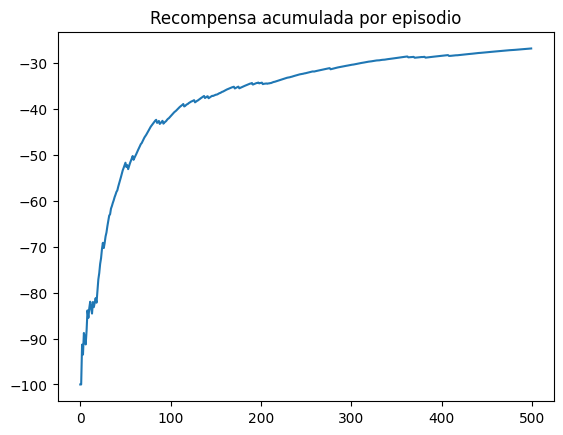

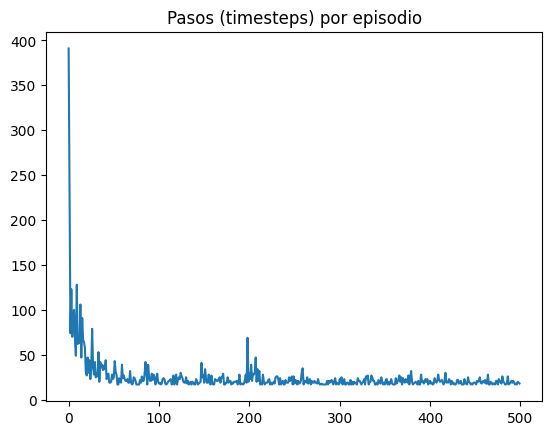

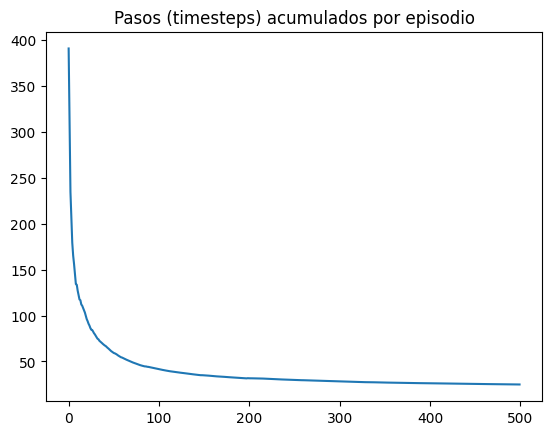

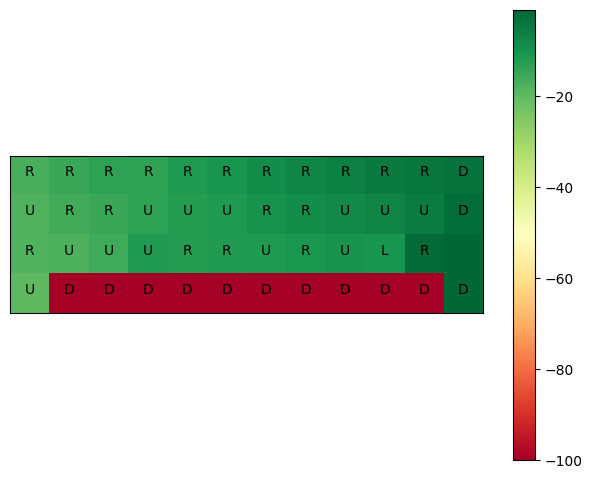


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [11]:
plot_reward_per_episode(reward_sarsa)
plot_steps_per_episode(timesteps_sarsa)
plot_steps_per_episode_smooth(timesteps_sarsa)
draw_value_matrix(q_sarsa)

# Q Learning

In [12]:
avg_reward_qlearning, timesteps_qlearning, reward_qlearning = run(
    learning_function=learning_function_qlearning,
    hyperparameters=hyperparameters_qlearning,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_qlearning,
    random_state=random_state
)

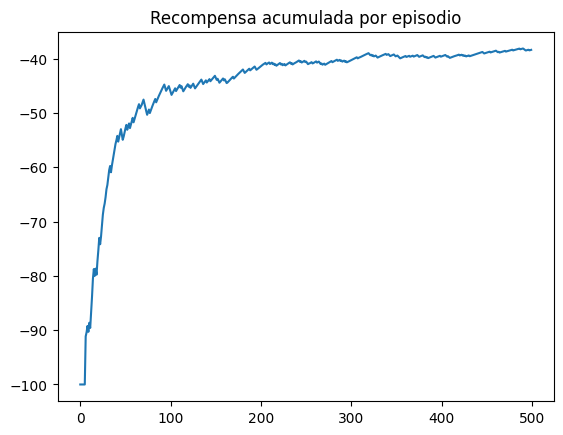

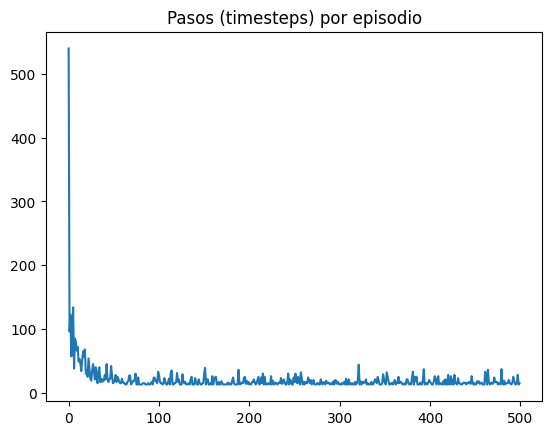

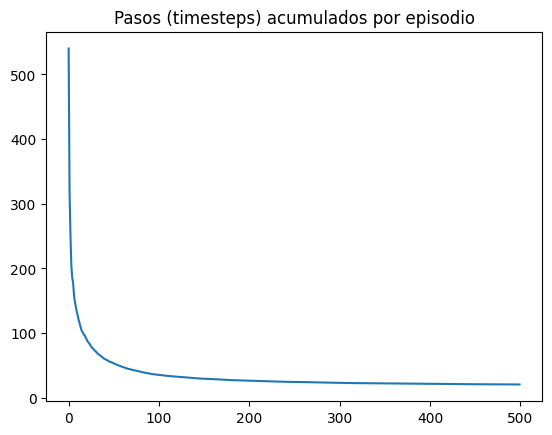

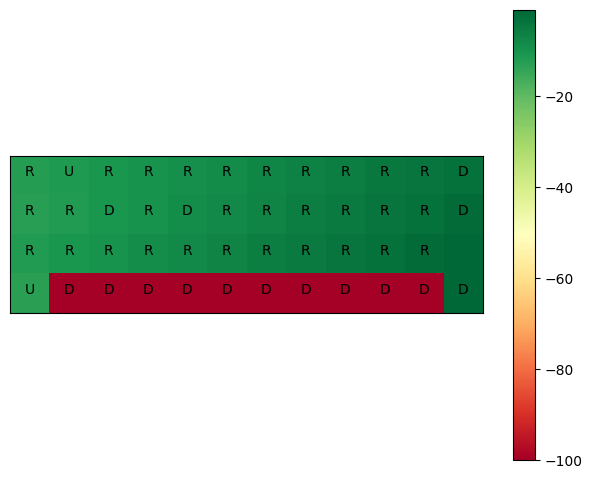


 Matriz de mejor acción-valor (en números): 

 [[ -12.48472403  -11.81064187  -11.00431373  -10.20913198   -9.3641749
    -8.422848     -7.4423576    -6.58166968   -5.69628889   -4.82410143
    -3.9456591    -2.99608014]
 [ -12.95845179  -11.98895659  -10.99756429   -9.99910145   -8.99960434
    -7.99973663   -6.99987299   -5.99996579   -4.99999528   -3.9999984
    -2.9999996    -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [13]:
plot_reward_per_episode(reward_qlearning)
plot_steps_per_episode(timesteps_qlearning)
plot_steps_per_episode_smooth(timesteps_qlearning)
draw_value_matrix(q_qlearning)

# Análisis de la ejecución del agente

## Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

SARSA


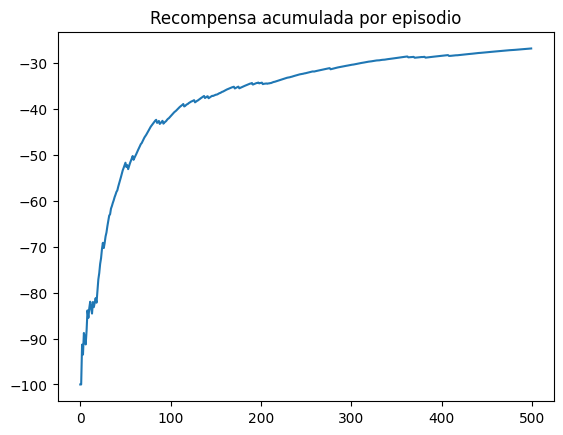

Q LEARNING


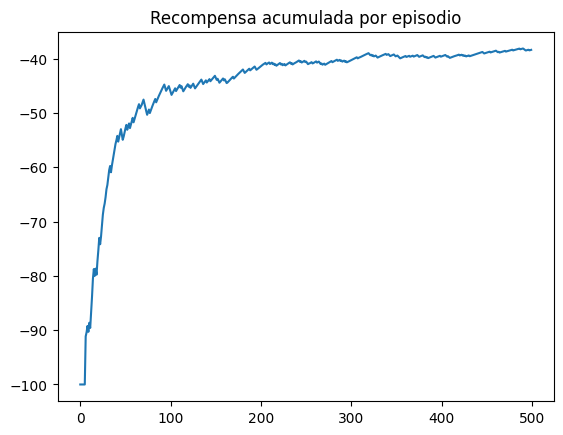

In [14]:
print("SARSA")
plot_reward_per_episode(reward_sarsa)
print("Q LEARNING")
plot_reward_per_episode(reward_qlearning)

Q-learning parece alcanzar un valor de recompensa más alto y más rápidamente que SARSA, mostrando una curva de aprendizaje un poco más rápida. SARSA, por su algoritmo on policy genera una curva menos agresiva al ascender, a diferencia de Q-learning (algoritmo off policy) que muestra más fluctuaciones al buscar optimizar a la mejor acción posible. Al final de los episodios, ambos algoritmos se estabilizan en un valor de recompensa similar

Veamos pasos por episodio

SARSA


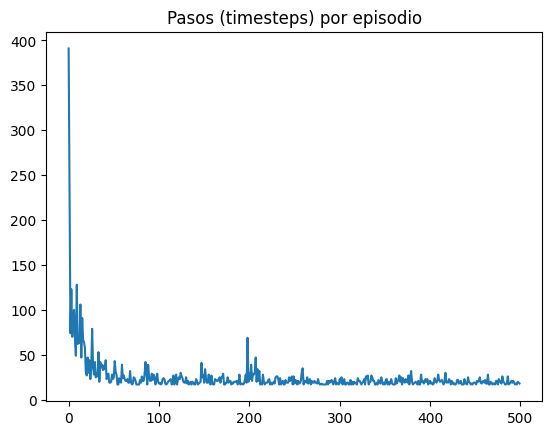

Q LEARNING


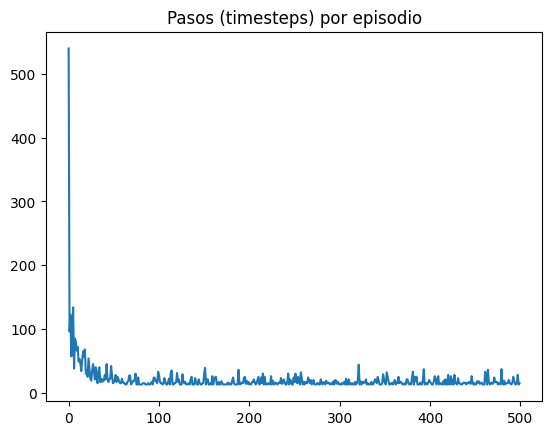

In [15]:
print("SARSA")
plot_steps_per_episode(timesteps_sarsa)
print("Q LEARNING")
plot_steps_per_episode(timesteps_qlearning)

En general, ambos algoritmos están logrando aprender una política que minimiza los pasos para alcanzar el objetivo, logrando estabilizarse luego de, aproximadamente, 100 episodios. SARSA parece ser más estable a largo plazo, mientras que Q-learning muestra más fluctuaciones y "picos" debido a su enfoque de maximización de la recompensa a través de la política óptima.

Suavizando...

SARSA


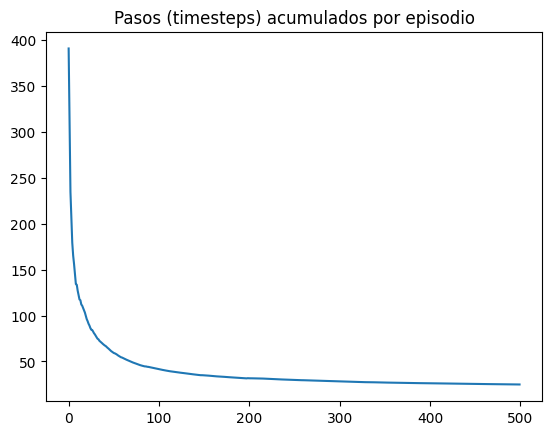

Q LEARNING


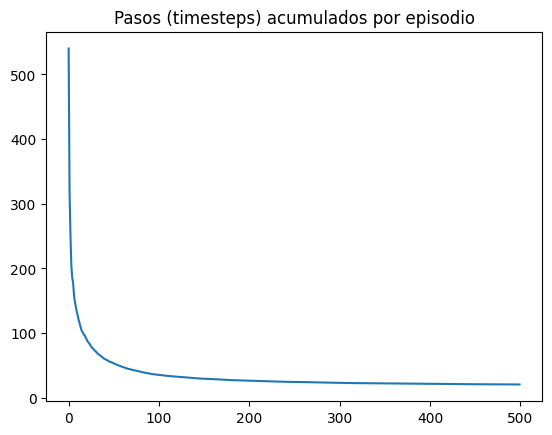

In [16]:
print("SARSA")
plot_steps_per_episode_smooth(timesteps_sarsa)
print("Q LEARNING")
plot_steps_per_episode_smooth(timesteps_qlearning)

## Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

### SARSA

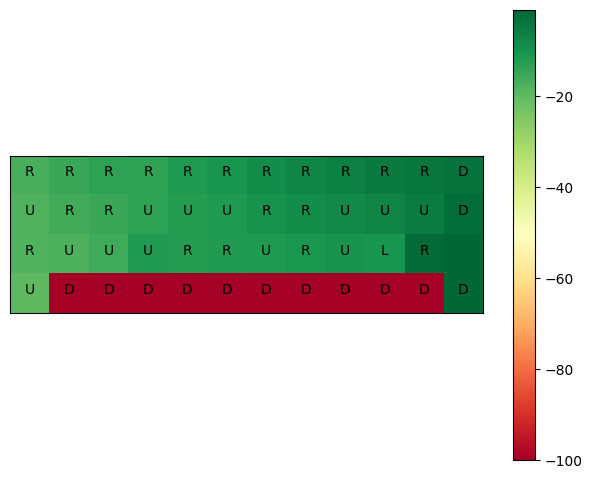


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [17]:
draw_value_matrix(q_sarsa)

### Q-Learning

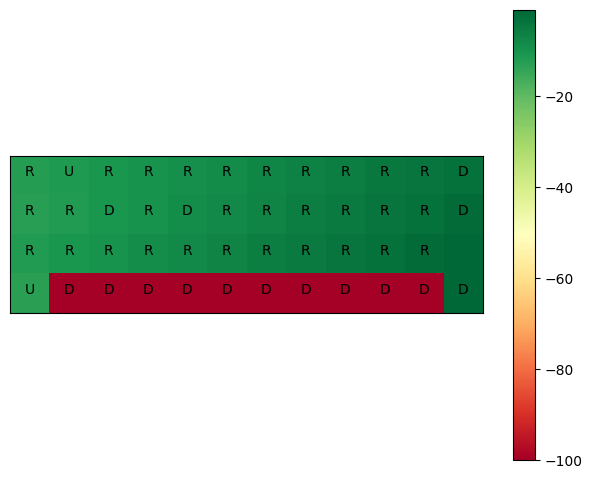


 Matriz de mejor acción-valor (en números): 

 [[ -12.48472403  -11.81064187  -11.00431373  -10.20913198   -9.3641749
    -8.422848     -7.4423576    -6.58166968   -5.69628889   -4.82410143
    -3.9456591    -2.99608014]
 [ -12.95845179  -11.98895659  -10.99756429   -9.99910145   -8.99960434
    -7.99973663   -6.99987299   -5.99996579   -4.99999528   -3.9999984
    -2.9999996    -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [18]:
draw_value_matrix(q_qlearning)

En ambos gráficos, se ve una clara separación entre las celdas verdes (seguras) y las celdas rojas (peligrosas), lo que indica que ambos algoritmos aprendieron a evitar el acantilado. Q-learning muestra una frontera más nítida y consistente de valores en estas zonas peligrosas, mientras que SARSA parece tener más variación en las direcciones de las acciones y colores más suaves cerca de los bordes del acantilado.

# Actividad 3

Hiperparámetros que afectan a la convergencia: $\alpha$, $\epsilon$ y $\gamma$.


$\alpha$ representa la tasa de aprendizaje: Controla la rapidez con la que el agente actualiza los valores de *Q(s,a)*. A mayor $\alpha$ (por ejemplo, 0.8), mayor velocidad de aprendizaje del agente. A Menor $\alpha$ (por ejemplo, 0.1), menor velocidad de aprendizaje del agente. Es importante considerar la estabilidad del aprendizaje, ya que un $\alpha$ muy grande implica un aprendizaje más inestable, mientras que un $\alpha$ menor puede resultar en una convergencia más estable

$\gamma$ representa el factor de descuento: Define cuánto valora el agente las recompensas futuras en comparación con las inmediatas. Un valor alto de $\gamma$ (por ejemplo, como 0.99) hace que el agente considere más las recompensas futuras, buscando maximizar la recompensa a largo plazo. Mientras que un valor bajo (por ejemplo, 0.5) hace que el agente se concentre en recompensas inmediatas, lo cual puede producir una política que no optimiza a largo plazo.

$\epsilon$ representa la exploración en $\epsilon$-greedy: Controla cuánto explora el agente acciones aleatorias en lugar de explotar las acciones que ya conoce. Valores altos de $\epsilon$ (por ejemplo, 0.5) hacen que el agente explore más, lo que ayuda a evitar estancarse en un óptimo local, pero puede hacer que el aprendizaje sea más lento. Valores bajos (por ejemplo, 0.01) hacen que el agente explote las acciones ya conocidas, lo que acelera la convergencia pero con el riesgo de quedarse en una política subóptima si no explora lo suficiente.

Para explorar el impacto de los hiperparámetros, se va a modificar los Hiperparámetros gradualmente, cambiando uno de los hiperparámetros a la vez mientras que los otros se mantienen constantes.

### Exploración de la tasa de aprendizaje $\alpha$

In [19]:
configs = [
    {"alpha": 0.1, "gamma": 1, "epsilon": 0.1},
    {"alpha": 0.5, "gamma": 1, "epsilon": 0.1},
    {"alpha": 0.8, "gamma": 1, "epsilon": 0.1},
]

#### SARSA

--- INICIO -----
config:  {'alpha': 0.1, 'gamma': 1, 'epsilon': 0.1}


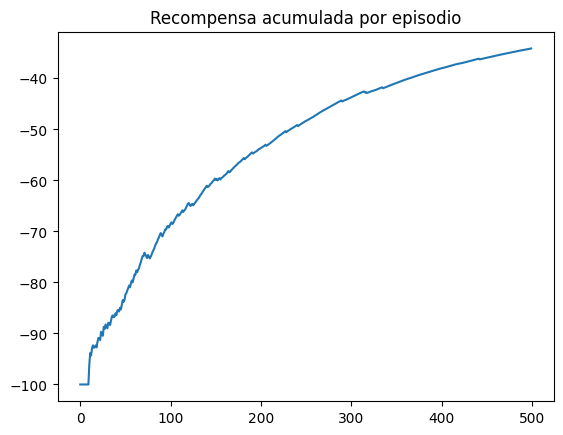

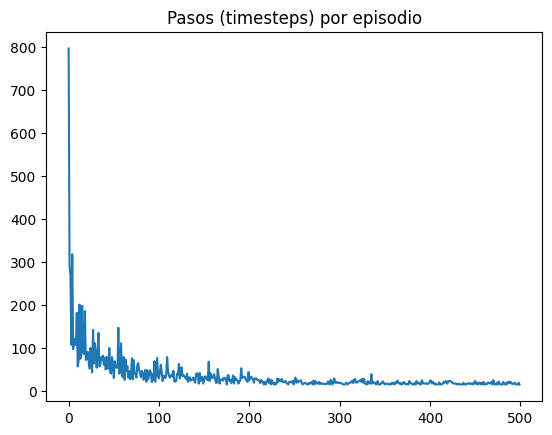

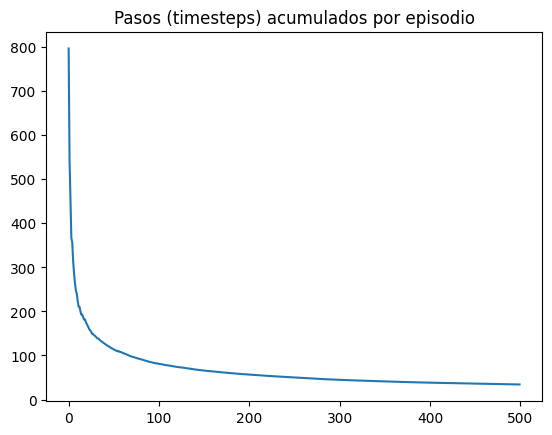

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


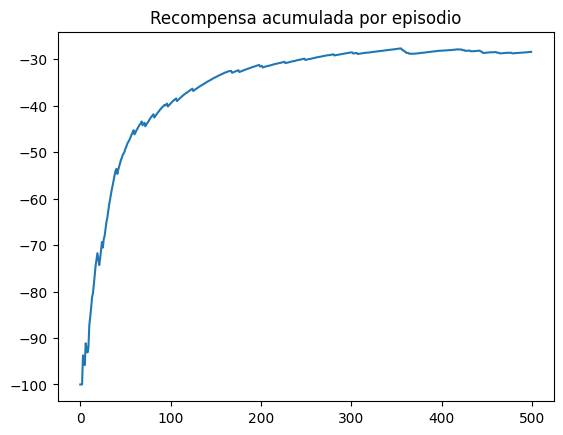

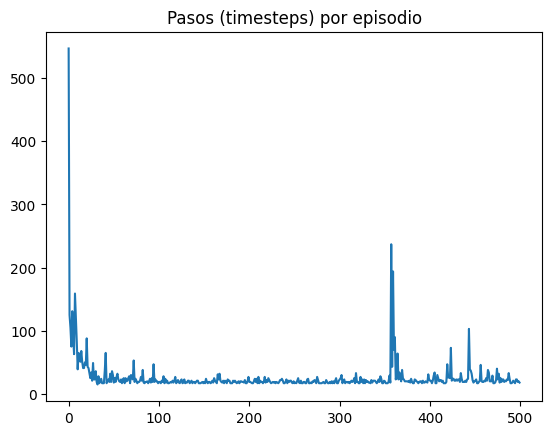

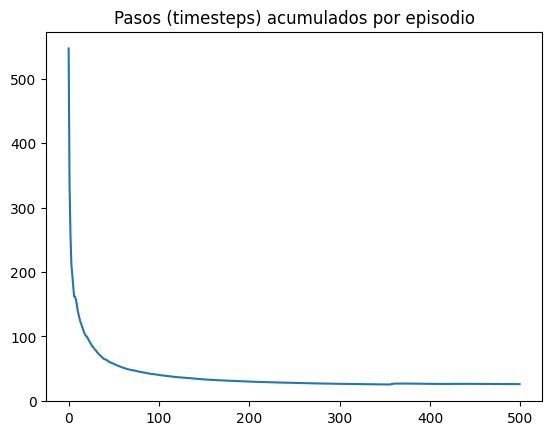

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.8, 'gamma': 1, 'epsilon': 0.1}


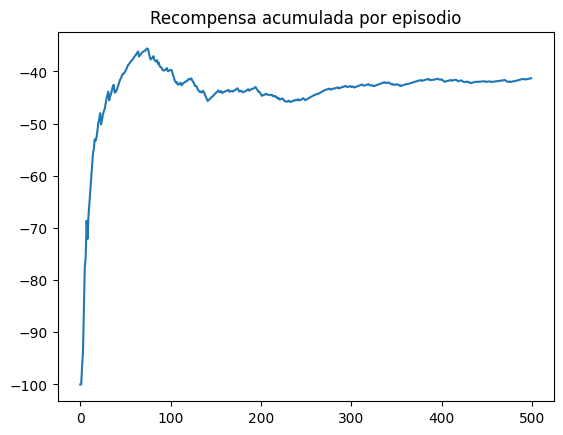

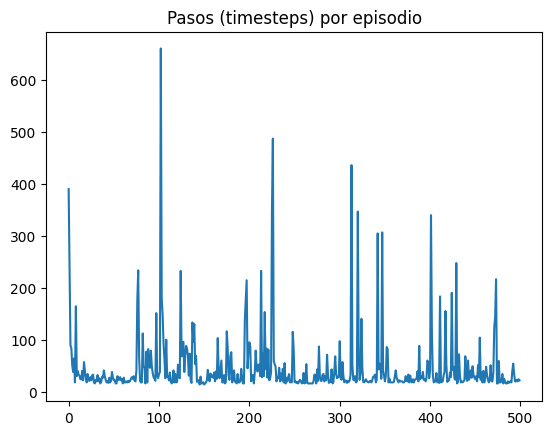

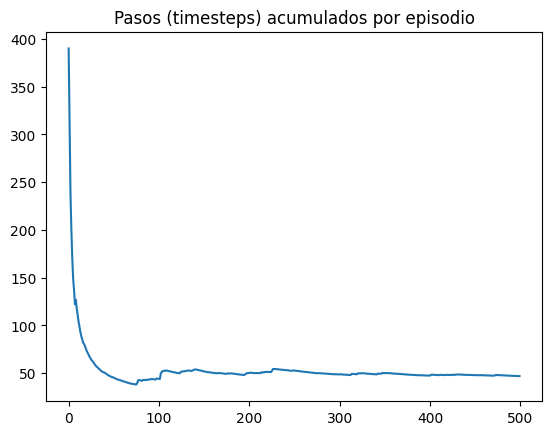

---- FIN --------


In [20]:
for config in configs:
    avg_reward_sarsa_exp, timesteps_sarsa_exp, reward_sarsa_exp = run(
        learning_function=learn_SARSA,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_sarsa_exp)
    plot_steps_per_episode(timesteps_sarsa_exp)
    plot_steps_per_episode_smooth(timesteps_sarsa_exp)
    print("---- FIN --------")

Al principio, cuando $\alpha$ = 0.1 la recompensa crece gradualmente, de manera estable y sin grandes fluctuaciones. Este valor hace que el aprendizaje sea más lento pero la pendiente se muestra consistente. Cuando $\alpha$ crece a 0.5, la recompensa acumulada también incrementa y alcanza un valor más alto en menos episodios, sin embargo se comienzan a apreciar algunas fluctuaciones, se observa un equilibrio entre estabilidad y rapidez en el aprendizaje. Finalmente, con $\alpha$ = 0.8, las fluctuaciones son más significativas, la convergencia es menos estable y tiene más variabilidad, lo que sugiere inestabilidad en la política aprendida.

#### Q Learning

--- INICIO -----
config:  {'alpha': 0.1, 'gamma': 1, 'epsilon': 0.1}


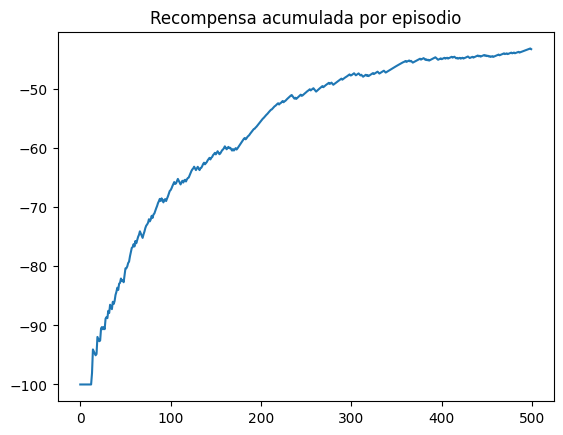

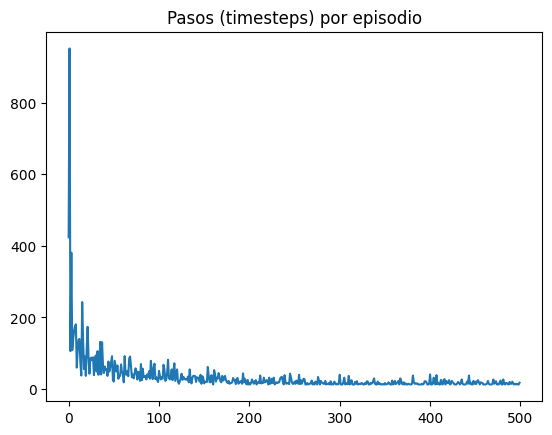

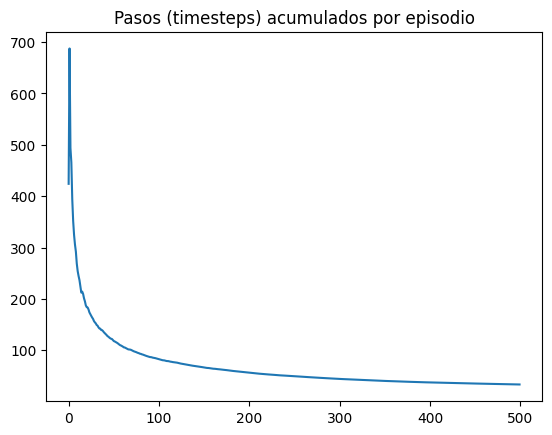

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


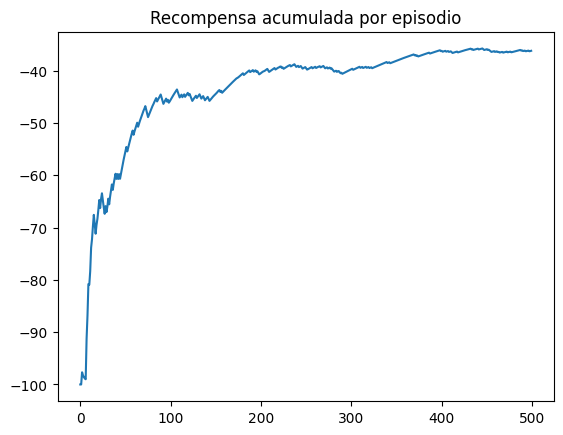

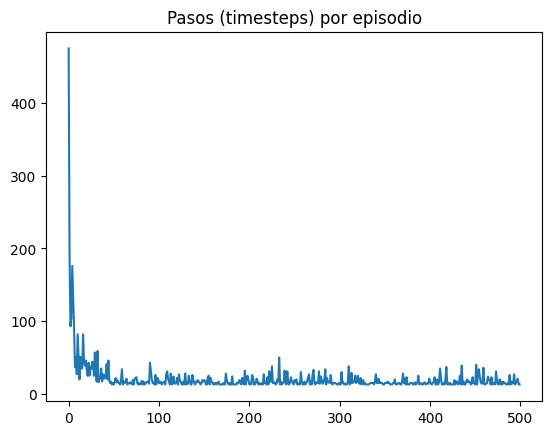

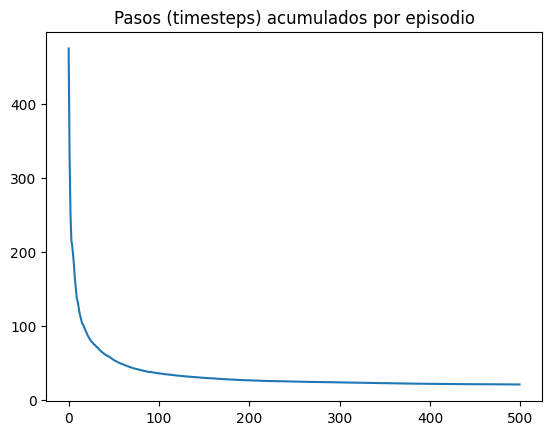

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.8, 'gamma': 1, 'epsilon': 0.1}


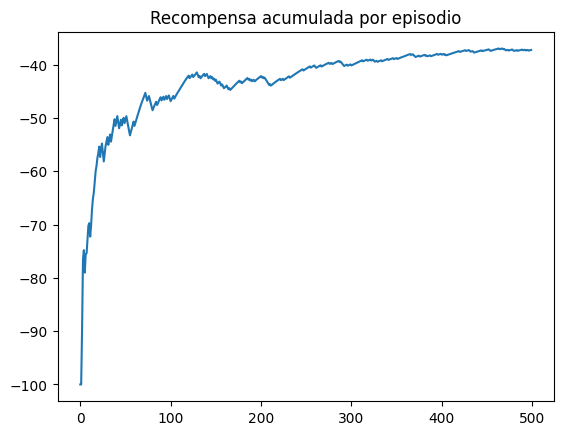

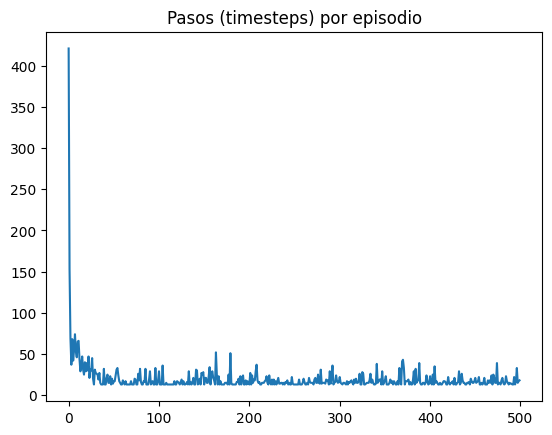

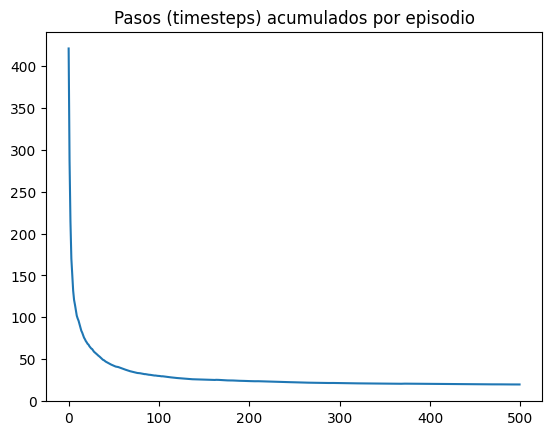

---- FIN --------


In [21]:
for config in configs:
    avg_reward_qlearning_exp, timesteps_qlearning_exp, reward_qlearning_exp = run(
        learning_function=learn_Q_learning,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_qlearning_exp)
    plot_steps_per_episode(timesteps_qlearning_exp)
    plot_steps_per_episode_smooth(timesteps_qlearning_exp)
    print("---- FIN --------")

Las tendencias generales observadas con SARSA se mantienen al analizar Q Learning, pero al ser un algoritmo off policy que optimiza directamente la política óptima sin depender de las acciones que toma el agente, al incrementar $\alpha$, q learning se vuelve más inestable que SARSA, mostrando fluctuaciones significativas en la recompensa acumulada. Para $\alpha$ = 0.8 la curva de recompensa acumulada presenta más oscilaciones en comparación con SARSA, también reduce los pasos por episodio a mayor velocidad que SARSA pero con picos más pronunciados y frecuentes. Esto muestra que q learning puede encontrar una política óptima más rápido, pero a costa de introducir inestabilidad en la eficiencia de las acciones tomadas.

### Exploración de el factor de descuento $\gamma$

In [22]:
configs = [
    {"alpha": 0.5, "gamma": 1, "epsilon": 0.1},
    {"alpha": 0.5, "gamma": 0.6, "epsilon": 0.1},
    {"alpha": 0.5, "gamma": 0.2, "epsilon": 0.1},
]

#### SARSA

--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


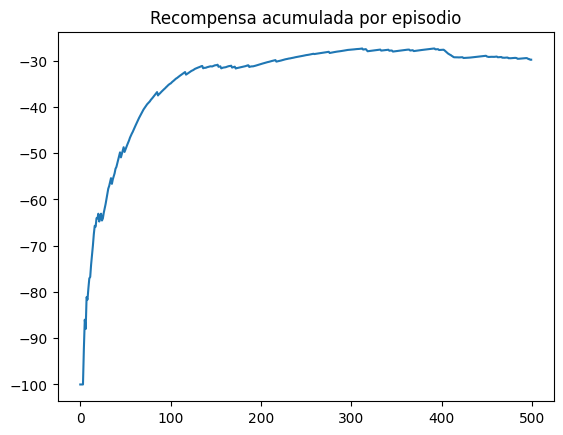

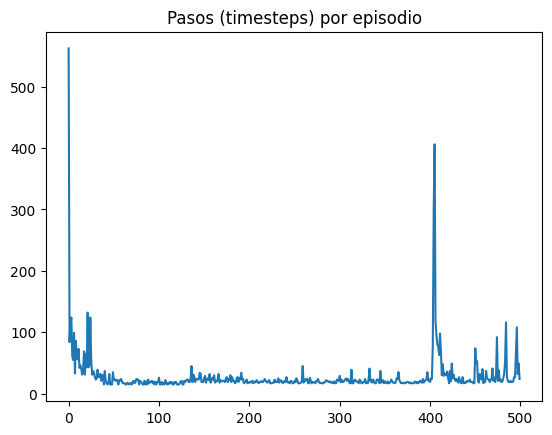

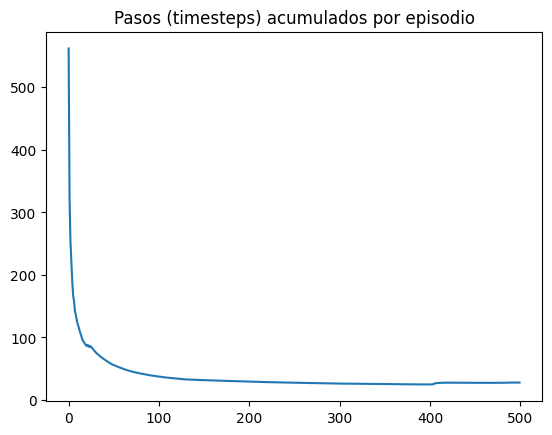

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 0.6, 'epsilon': 0.1}


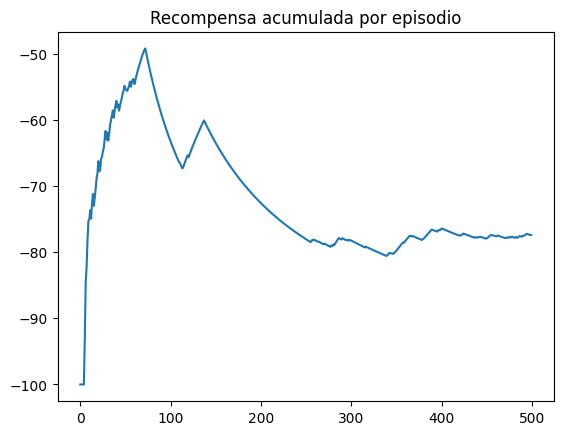

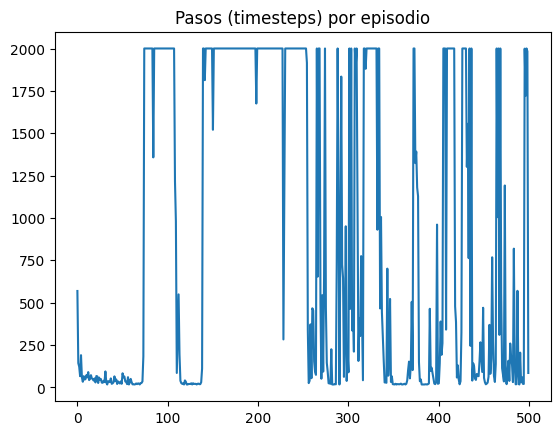

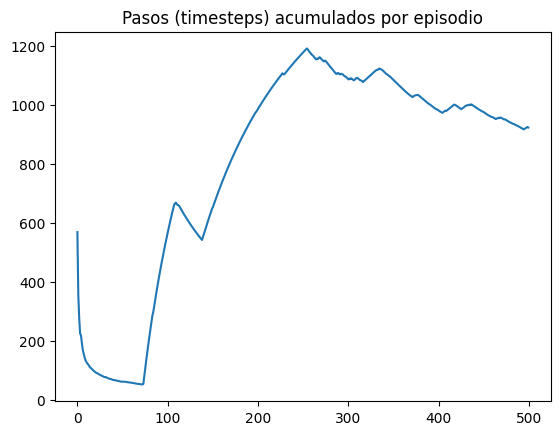

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 0.2, 'epsilon': 0.1}


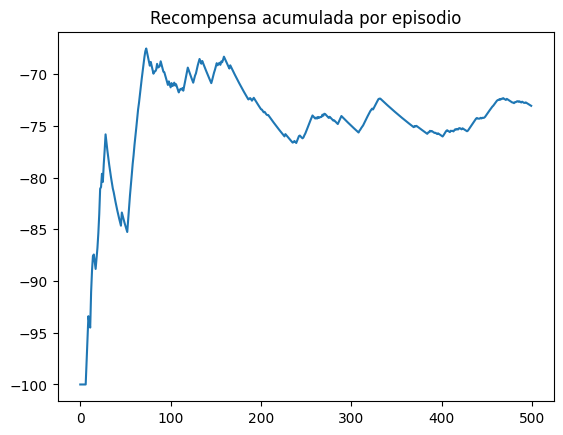

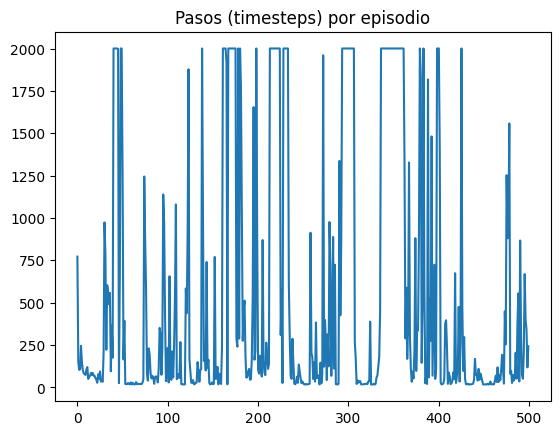

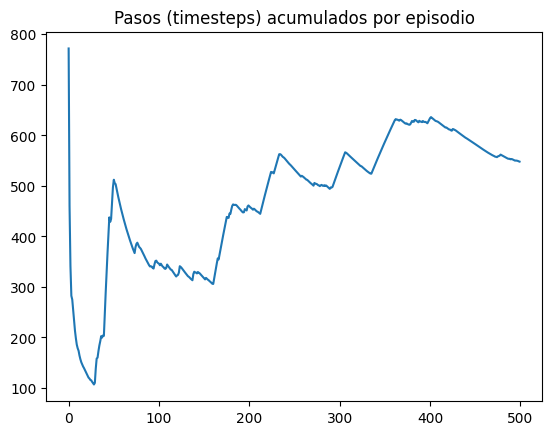

---- FIN --------


In [23]:
for config in configs:
    avg_reward_sarsa_exp, timesteps_sarsa_exp, reward_sarsa_exp = run(
        learning_function=learn_SARSA,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_sarsa_exp)
    plot_steps_per_episode(timesteps_sarsa_exp)
    plot_steps_per_episode_smooth(timesteps_sarsa_exp)
    print("---- FIN --------")

Cuando $\gamma$ = 1, la curva de recompensa acumulada crece y se estabiliza rapidamente, así mismo hay una rapida disminución en los pasos durante los primeros episodios. Si bien se observan algunos picos en episodios tardíos, la tendencia general muestra que el agente aprendió a optimizar la recompensa a largo plazo, considerando tanto las recompensas inmediatas como las futuras. Cuando $\gamma$ decrece a 0.6, la curva de recompensa muestra un crecimiento inicial rápido pero luego comienza a decaer significativamente, mientras que la curva de pasos por episodio es mucho más irregular. Este comportamiento indica que el agente no está aprendiendo una política eficiente, ya que está priorizando recompensas inmediatas en lugar de considerar el impacto a largo plazo, lo que puede llevar a rutas subóptimas que no minimizan los pasos necesarios. Finalmente, con $\gamma$ en 0.2, la falta de estabilidad en la recompensa acumulada, con fluctuaciones evidentes, indica que el agente no está logrando aprender una política consistente. Mientras que la curva de pasos por episodio es extremadamente irregular, con frecuentes episodios alcanzando el límite de 2000 pasos.

#### Q learning

--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


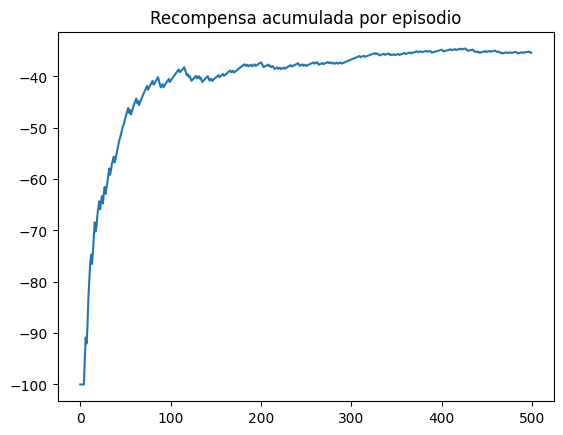

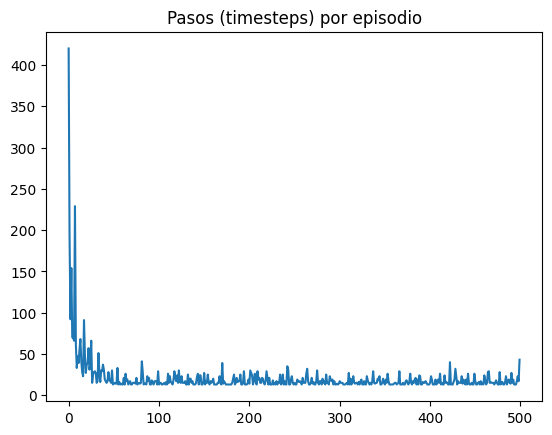

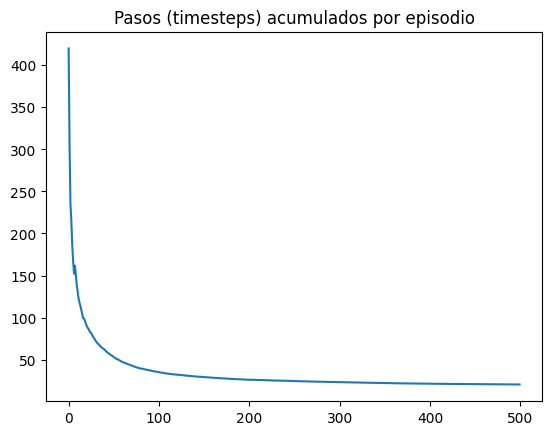

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 0.6, 'epsilon': 0.1}


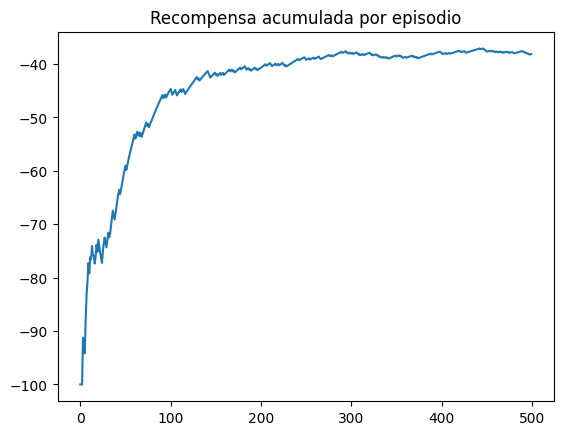

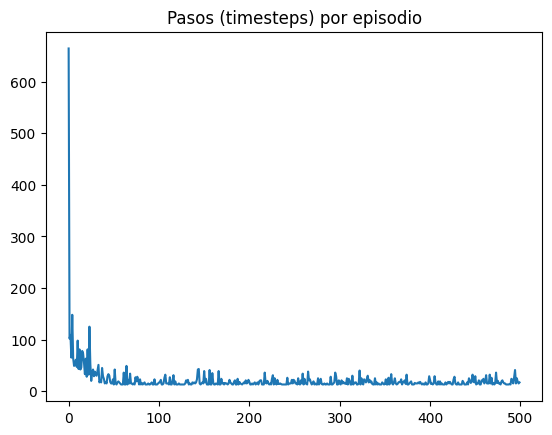

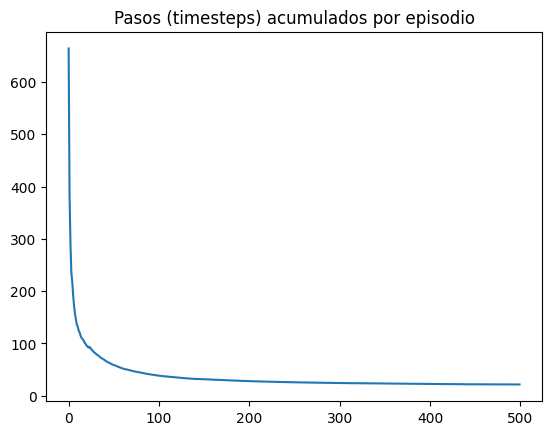

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 0.2, 'epsilon': 0.1}


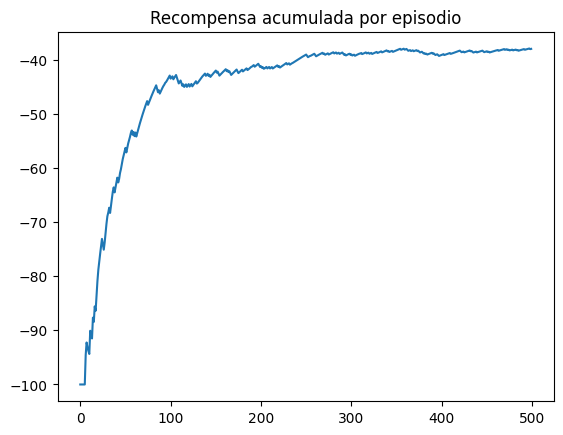

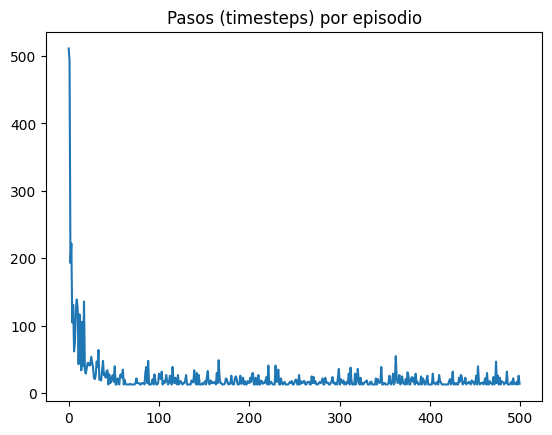

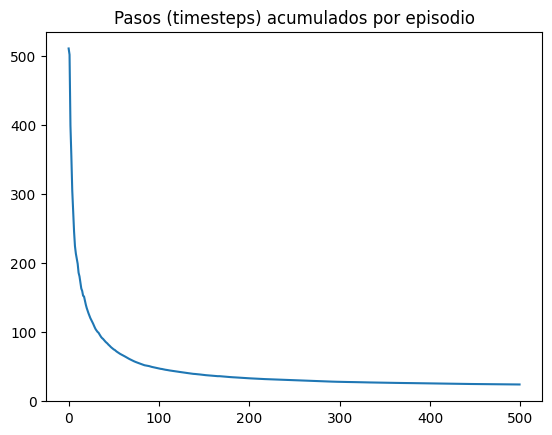

---- FIN --------


In [24]:
for config in configs:
    avg_reward_qlearning_exp, timesteps_qlearning_exp, reward_qlearning_exp = run(
        learning_function=learn_Q_learning,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_qlearning_exp)
    plot_steps_per_episode(timesteps_qlearning_exp)
    plot_steps_per_episode_smooth(timesteps_qlearning_exp)
    print("---- FIN --------")

Como con  $\alpha$, las tendencias generales observada en SARSA se mantienen en Q learning, pero por su naturaleza off policy logra manejar mejor la inestabilidad cuando $\gamma$ decrece. Se observa en $\gamma$ = 0.6 que la estabilidad sigue siendo buena en la curva de recompensa, si bien se pueden observar pequeñas fluctuaciones en episodios tardíos. Los pasos por episodio disminuyen rápidamente pero comienzan a aparecer más picos que con  $\gamma$ = 1, logrando el agente una política razonablemente eficiente pese a priorizar más las recompensas inmediatas que las futuras. Con  $\gamma$ = 0.2, aunque el agente encuentra rutas eficientes al principio, las decisiones a corto plazo generan picos ocasionales, lo que refleja una política miope

### Exploración de la exploración en $\epsilon$-greedy $\epsilon$

In [25]:
configs = [
    {"alpha": 0.5, "gamma": 1, "epsilon": 0.1},
    {"alpha": 0.5, "gamma": 1, "epsilon": 0.5},
    {"alpha": 0.5, "gamma": 1, "epsilon": 0.9},
]

#### SARSA

--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


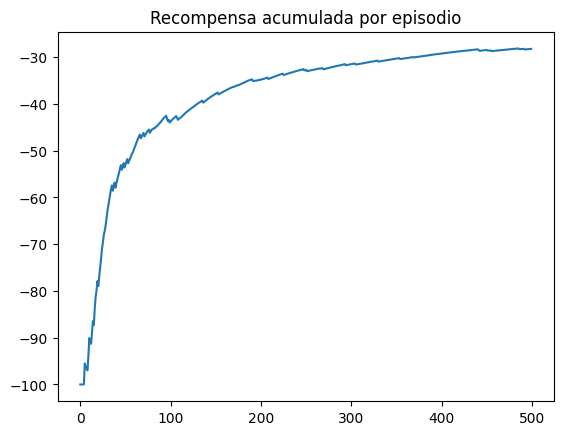

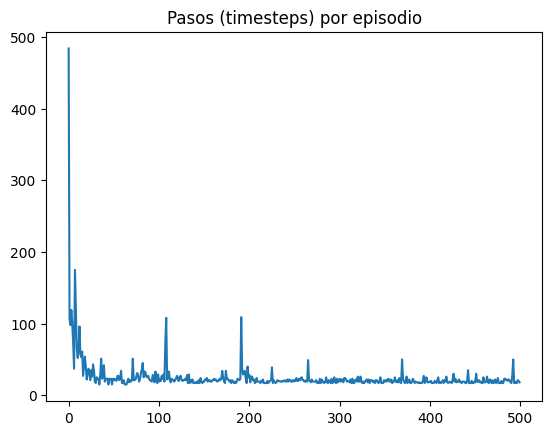

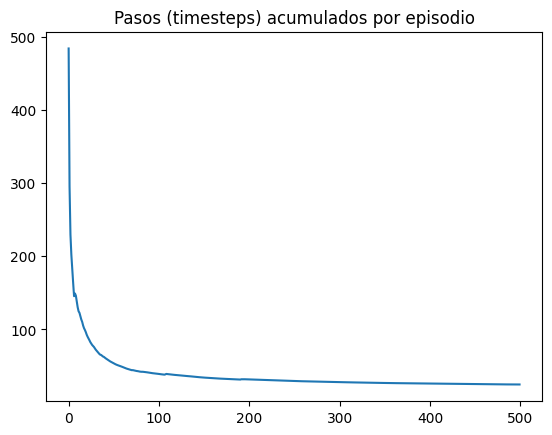

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.5}


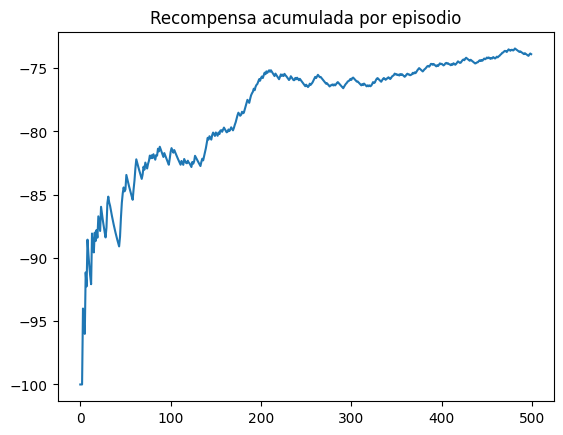

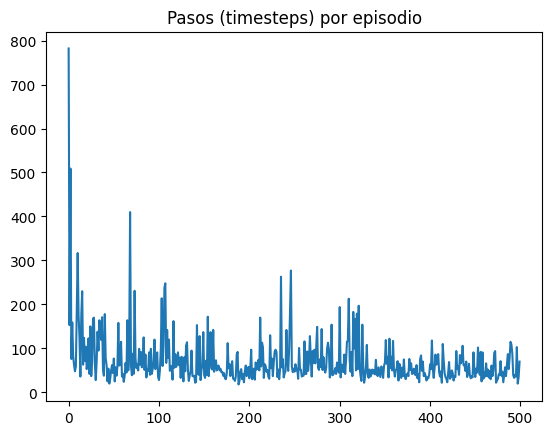

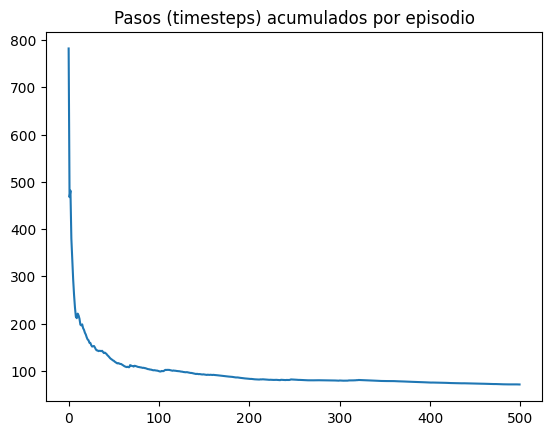

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.9}


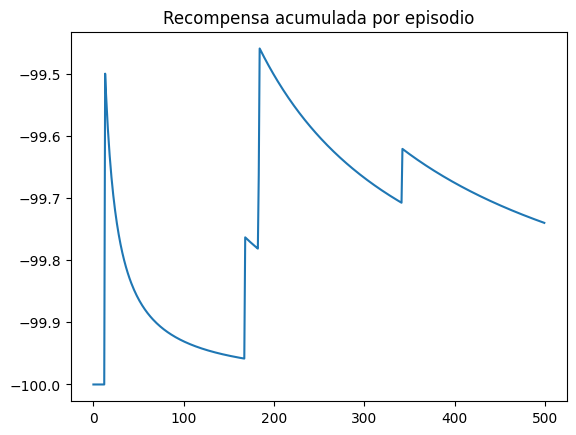

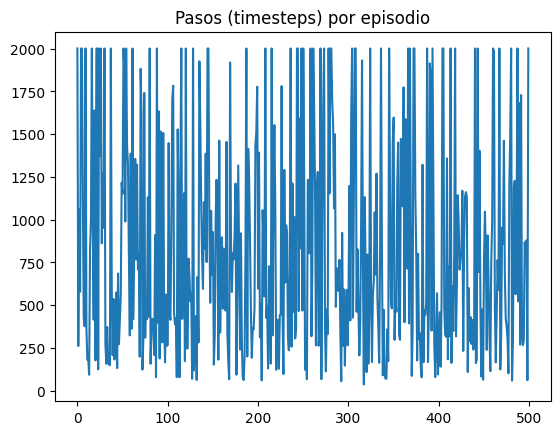

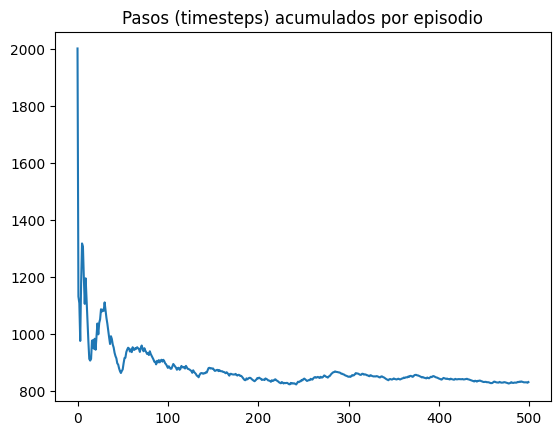

---- FIN --------


In [26]:
for config in configs:
    avg_reward_sarsa_exp, timesteps_sarsa_exp, reward_sarsa_exp = run(
        learning_function=learn_SARSA,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_sarsa_exp)
    plot_steps_per_episode(timesteps_sarsa_exp)
    plot_steps_per_episode_smooth(timesteps_sarsa_exp)
    print("---- FIN --------")

Con $\epsilon$ = 0.1 el agente parece explorar poco y ajustar su política en base a las recompensas observadas, como se ve por la disminución consistente de los pasos con pocos picos. A medida que $\epsilon$ comienza a crecer, la recompensa crece más lentamente y converge hacia un valor más bajo, probando nuevas rutas a costa de un menor rendimiento. En lo pasos se comienza a apreciar una mayor variabilidad, con algunos picos si bien disminuyen con el tiempo. Cuando $\epsilon$ se define en 0.9, la recompensa es extremadamente baja y no muestra signos de mejora. Por su parte, los pasos son altamente irregulares, con muchos episodios alcanzando el límite de 2000 pasos. El agente no aprende una política eficiente debido al exceso de exploración

#### Q Learning

--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.1}


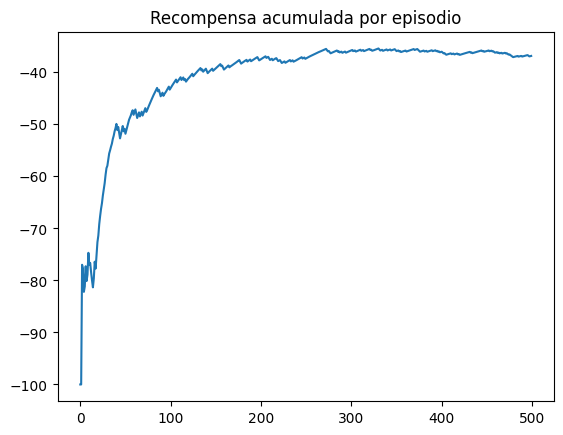

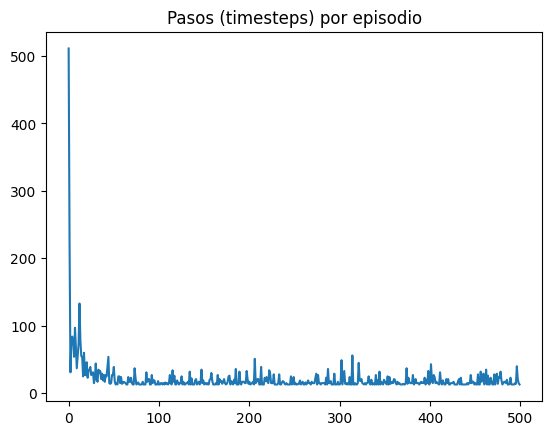

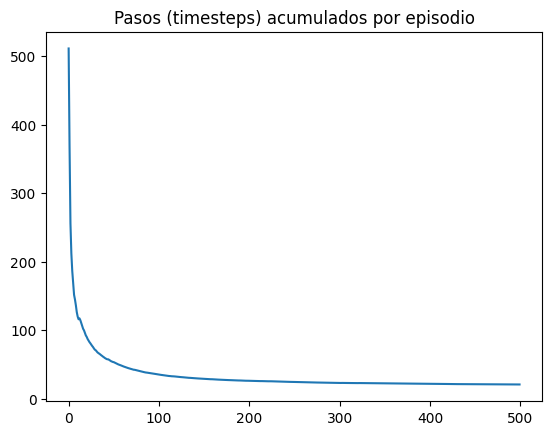

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.5}


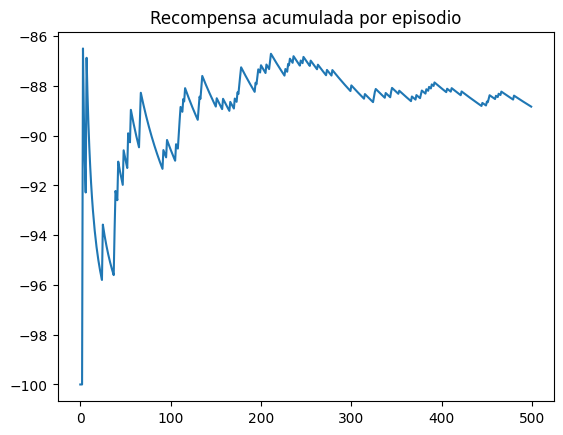

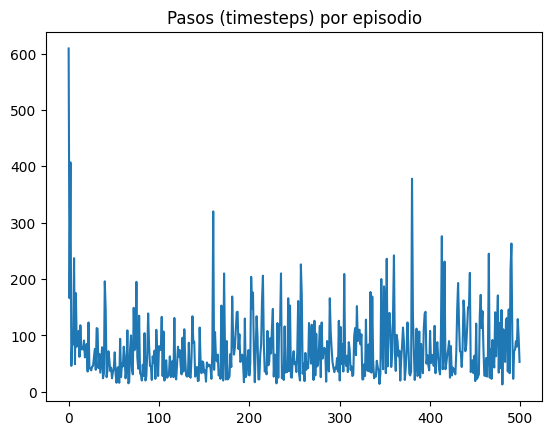

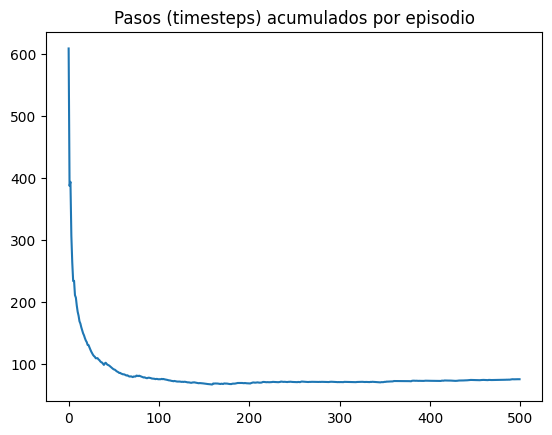

---- FIN --------
--- INICIO -----
config:  {'alpha': 0.5, 'gamma': 1, 'epsilon': 0.9}


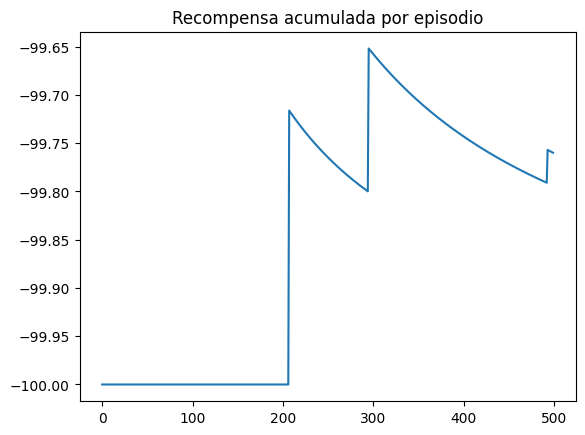

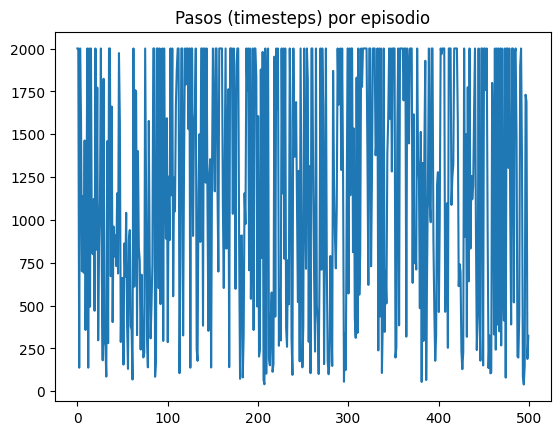

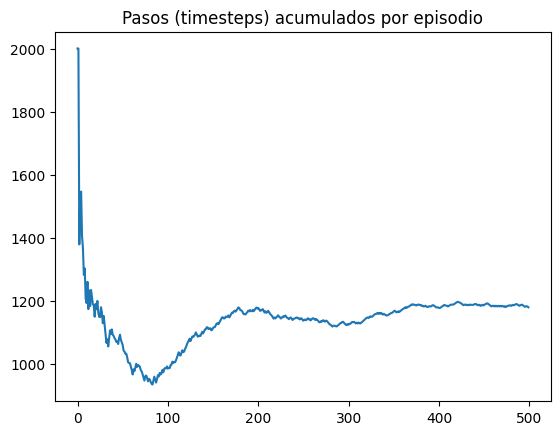

---- FIN --------


In [27]:
for config in configs:
    avg_reward_qlearning_exp, timesteps_qlearning_exp, reward_qlearning_exp = run(
        learning_function=learn_Q_learning,
        hyperparameters=config,
        episodes_to_run=500,
        env=env,
        actions=actions,
        q={},
        random_state=random_state
    )
    print("--- INICIO -----")
    print("config: ", config)
    plot_reward_per_episode(reward_qlearning_exp)
    plot_steps_per_episode(timesteps_qlearning_exp)
    plot_steps_per_episode_smooth(timesteps_qlearning_exp)
    print("---- FIN --------")

Las tendencias generales observadas en SARSA se mantienen con un algoritmo q learning, siendo que cuando $\epsilon$ es bajo, la recompensa crece consistentemente hasta alcanzar un valor alto, mientras que los pasos disminuyen de manera constante y estable con pocos picos. Sin embargo, al comenzar a incrementar $\epsilon$, q learning presenta más fluctuaciones en la recompensa que SARSA, así como los pasos muestran mayor inestabilidad con muchos más picos. Con $\epsilon$ = 0.9, ambos algoritmos son afectados negativamente por una alta exploración, pero SARSA parece ser más sensible por su dependencia en las acciones exploradas, mientras que q learning, pese a ser ineficiente, tienda a consolidar recompensas ligeramente mejores.

# Actividad 4

In [28]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    q: dict,
    random_state: np.random.RandomState,
    actions: range,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual usando Softmax
        action = choose_action_softmax(
            state=state,
            actions=actions,
            q=q,
            hyperparameters=hyperparameters,
            random_state=random_state
        )

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            # elige la siguiente acción usando Softmax
            next_action = choose_action_softmax(
                state=next_state,
                actions=actions,
                q=q,
                hyperparameters=hyperparameters,
                random_state=random_state
            )

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                hyperparameters,
                q,
                next_action
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode


In [29]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q_sarsa = {}
q_qlearning = {}

# definimos sus híper-parámetros básicos

hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function_sarsa = learn_SARSA
learning_function_qlearning = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

## SARSA

In [30]:
avg_reward_sarsa, timesteps_sarsa, reward_sarsa = run(
    learning_function=learning_function_sarsa,
    hyperparameters=hyperparameters,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_sarsa,
    random_state=random_state
)

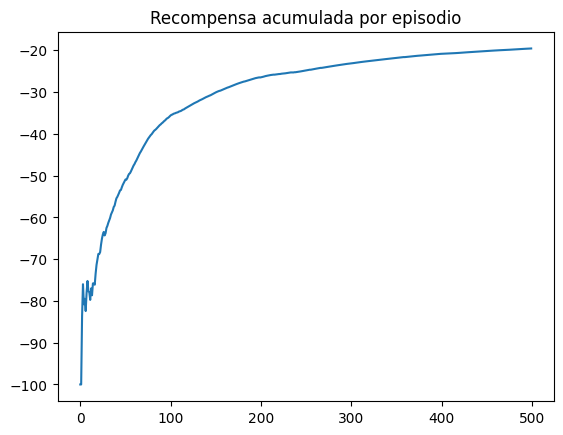

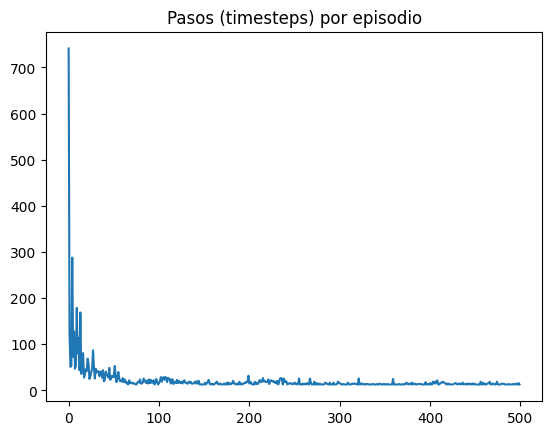

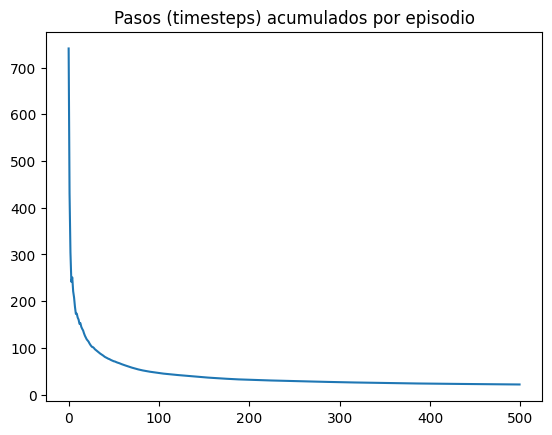

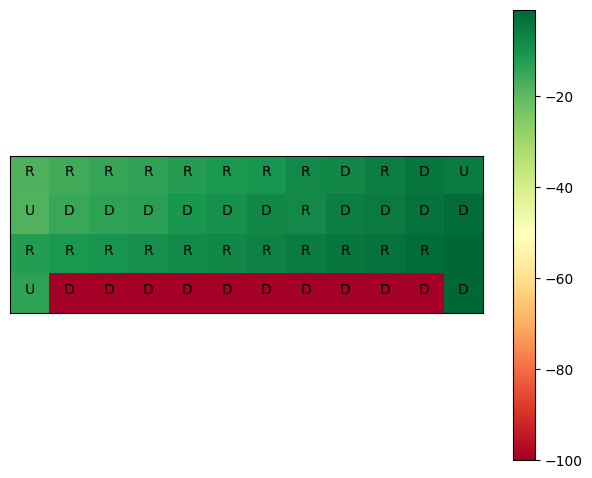


 Matriz de mejor acción-valor (en números): 

 [[ -18.00510287  -16.24230119  -14.8380336   -13.90765486  -12.5950594
   -11.25339744  -10.55825382   -8.25739336   -7.59621117   -5.93589286
    -4.42262119   -5.37456412]
 [ -18.25291834  -15.25798393  -13.52786117  -13.02752656  -10.83414877
    -9.64057969   -7.82644668   -8.02201806   -5.99351111   -4.92705481
    -3.56980001   -2.29956756]
 [ -12.37993865  -11.33072487  -10.2967419    -9.36271413   -8.62780537
    -7.82359815   -6.67672718   -5.41827292   -4.24743051   -3.35859085
    -2.27053572   -1.        ]
 [ -13.4587642  -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [31]:
plot_reward_per_episode(reward_sarsa)
plot_steps_per_episode(timesteps_sarsa)
plot_steps_per_episode_smooth(timesteps_sarsa)
draw_value_matrix(q_sarsa)

Con softmax, la recompensa acumulada converge rápidamente y se estabiliza mejor respecto greedy (-20 vs -30, respectivamente). Los pasos por episodio disminuyen rápidamente y se estabilizan en un nivel bajo (cercano a 0 en etapas finales), mientras que la curva de pasos acumulados tiene una forma típica de aprendizaje exitoso: un rápido crecimiento inicial seguido de estabilización. La matriz de valores muestra una política razonable y coherente: el agente evita el acantilado y se dirige directamente hacia la meta. Esta tendencia en la frontera del acantilado sugiere que el agente encuentra una ruta eficiente hacia la meta, evitando exploraciones innecesarias.

## Q learning

In [32]:
avg_reward_qlearning, timesteps_qlearning, reward_qlearning = run(
    learning_function=learning_function_qlearning,
    hyperparameters=hyperparameters,
    episodes_to_run=episodes_to_run,
    env=env,
    actions=actions,
    q=q_sarsa,
    random_state=random_state
)

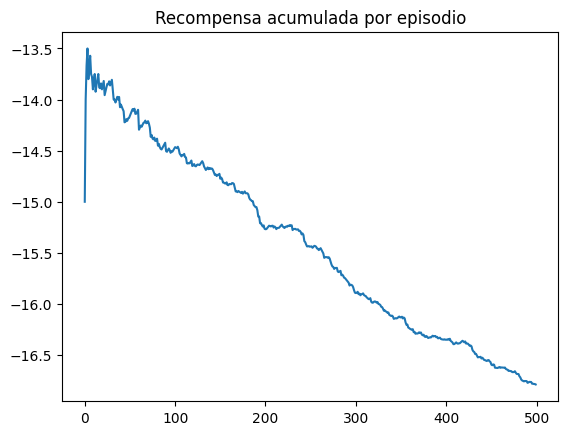

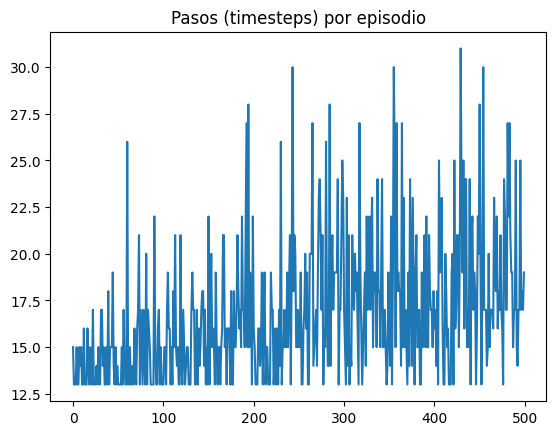

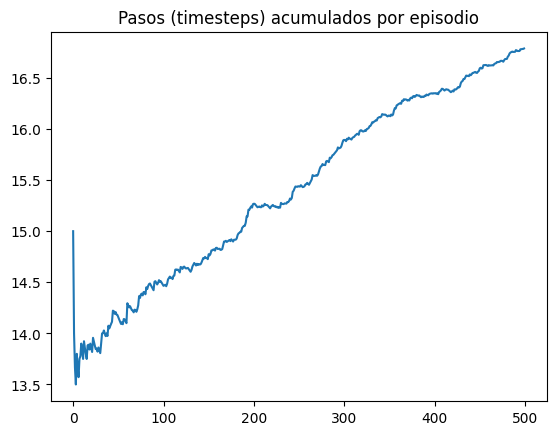

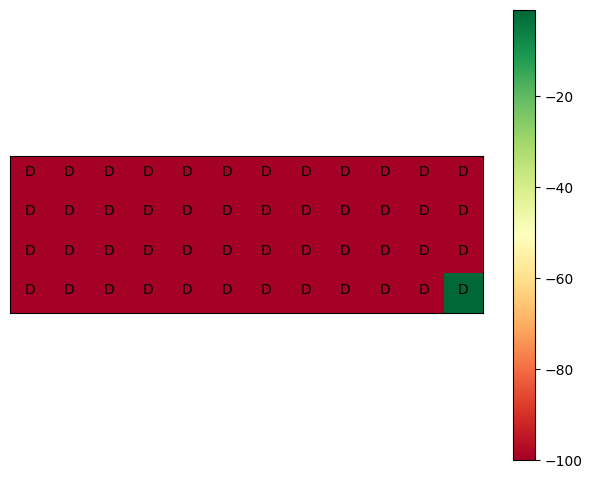


 Matriz de mejor acción-valor (en números): 

 [[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [33]:
plot_reward_per_episode(reward_qlearning)
plot_steps_per_episode(timesteps_qlearning)
plot_steps_per_episode_smooth(timesteps_qlearning)
draw_value_matrix(q_qlearning)

La recompensa acumulada en Q-learning muestra una disminución constante con el tiempo. Esto indica que el agente no está aprendiendo una política eficiente y sigue explorando activamente sin consolidar valores óptimos *Q(s,a)*. De igual manera, los pasos muestran una alta variabilidad y mucha menos estabilidad que en softmax-SARSA, o incluso comparado con greedy-q learning. Los pasos acumulados crecen continuamente, lo que refleja que el agente no converge a una política eficiente. La matriz de valores muestra una política completamente enfocada en acciones "D" (abajo), lo que podría indicar que el agente no logra discriminar entre las diferentes recompensas y simplemente opta por una exploración excesiva debido a la configuración de Softmax.

In [34]:
env.close()

# Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN